In [1]:
import time
import gym
import numpy as np
import control as ct
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import os
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
def split_forward_filter_fn(A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,z):
    '''Calculates prior distribution based on the previous posterior distribution
        and the current residual updates posterior distribution based on the new
        prior distribution
    '''
#     print('z',z)
#     print('A', A)
#     print('B',B)
#     print('u',u)
#     print('g',g)
#     print('sigma',sigma)
#     print('C', C)
#     print('l_a_posteriori', l_a_posteriori)
#     print('P_a_posteriori', P_a_posteriori)
    _I = tf.eye(int(A.shape[0]), dtype = tf.float64)
    
    z = tf.reshape(z,[1,1])
    l_a_priori = tf.matmul(A,l_a_posteriori) + tf.matmul(B,u)
#     print('l_a_priori',l_a_priori)
    P_a_priori = tf.matmul(tf.matmul(A,P_a_posteriori), A, transpose_b = True) + tf.matmul(g,g, transpose_b=True)
#     print('P_a_priori',P_a_priori)
    y_pre = z - tf.matmul(C,l_a_priori)
#     print('y_pre', y_pre)
    S = tf.square(sigma) + tf.matmul(tf.matmul(C, P_a_priori), C, transpose_b=True)
#     print('S',S)
    S_inv = tf.math.reciprocal(S)
#     print('S_inv', S_inv)
    K = tf.matmul(tf.matmul(P_a_priori, C, transpose_b=True), S_inv)
#     print('K', K)
    l_a_posteriori = l_a_priori + tf.matmul(K,y_pre)
#     print('l_a_posteriori', l_a_posteriori)
    I_KC = _I-tf.matmul(K,C)
#     print('I-KC', I_KC)
    P_a_posteriori = tf.matmul(tf.matmul(I_KC, P_a_priori), I_KC, transpose_b=True) + \
                        tf.matmul(tf.matmul(K,tf.matmul(sigma, sigma, transpose_b = True)),
                                K, transpose_b=True)
#     print('P_a_posteriori',P_a_posteriori)
    y_post = z-tf.matmul(C,l_a_posteriori)
    squared_error = tf.squeeze(tf.matmul(y_post,y_post, transpose_a=True))
#     print(squared_error)
#     print('y_post', y_post)
    pred = tf.matmul(C, l_a_posteriori)
#     print('pred', pred)

    return l_a_posteriori,P_a_posteriori,z, pred, squared_error

In [3]:
class split_KF_Model(object):
    def __init__(self, thetaacc_error = 0, env_params_variation = [0,0,0,0], initial_state_variation = [0,0,0,0], control = False):
        self.m = 4
        self.dim_z = self.m
        self.n = 4
        self.r = 1
        self.sigma_upper_bound = 0.1
        self.sigma_lower_bound = 0
        self.g_upper_bound = 1
        self.g_lower_bound = 0.1
        self.mu_0_upper_bound = 1
        self.mu_0_lower_bound = 0
        self.Sigma_0_upper_bound = 1
        self.Sigma_0_lower_bound = 0
        self.weight_beta = .1
        self.bias_beta = .1
        self.thetaacc_error = thetaacc_error
        self.global_epoch = 0
        
        self.mu_0_dense = tf.keras.Sequential([layers.Dense(self.m*8, activation = tf.sigmoid, kernel_regularizer = reg.l2(self.weight_beta),
                                                            bias_regularizer = reg.l2(self.bias_beta),name = 'mu_0_dense1'),
                                               layers.Dense(self.m, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l2(self.weight_beta),
                                                            bias_regularizer = reg.l2(self.bias_beta),name = 'mu_0_dense2')])
        self.Sigma_0_dense = tf.keras.Sequential([layers.Dense(self.m*8, activation = tf.sigmoid, kernel_regularizer = reg.l2(self.weight_beta),
                                                               bias_regularizer = reg.l2(self.bias_beta),name = 'Sigma_0dense1'),
                                                  layers.Dense(self.m, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l2(self.weight_beta),
                                                               bias_regularizer = reg.l2(self.bias_beta),name = 'Sigma_0dense2')])
        
        self.A_dense = tf.keras.Sequential([layers.Dense(self.m*self.n*8, activation = tf.sigmoid, kernel_regularizer = reg.l1(self.weight_beta),
                                                         bias_regularizer = reg.l2(self.bias_beta),name = 'A_dense1'),
                                            layers.Dense(self.m*self.n, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                                         bias_regularizer = reg.l2(self.bias_beta),name = 'A_dense2')])
        self.g_dense = tf.keras.Sequential([layers.Dense(self.m*8, activation = tf.sigmoid, kernel_regularizer = reg.l1(self.weight_beta),
                                                         bias_regularizer = reg.l2(self.bias_beta),name = 'g_dense1'),
                                            layers.Dense(self.m, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                                         bias_regularizer = reg.l2(self.bias_beta),name = 'g_dense2')])
        self.sigma1_dense = tf.keras.Sequential([layers.Dense(1*8, activation = tf.sigmoid, kernel_regularizer = reg.l1(self.weight_beta),
                                                              bias_regularizer = reg.l2(self.bias_beta),name = 'sigma1_dense1'),
                                                 layers.Dense(1, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                                              bias_regularizer = reg.l2(self.bias_beta),name = 'sigma1_dense2')])
        self.sigma2_dense = tf.keras.Sequential([layers.Dense(1*8, activation = tf.sigmoid, kernel_regularizer = reg.l1(self.weight_beta),
                                                              bias_regularizer = reg.l2(self.bias_beta),name = 'sigma2_dense1'),
                                                 layers.Dense(1, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                                              bias_regularizer = reg.l2(self.bias_beta),name = 'sigma2_dense2')])
        self.sigma3_dense = tf.keras.Sequential([layers.Dense(1*8, activation = tf.sigmoid, kernel_regularizer = reg.l1(self.weight_beta),
                                                              bias_regularizer = reg.l2(self.bias_beta),name = 'sigma3_dense1'),
                                                 layers.Dense(1, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                                              bias_regularizer = reg.l2(self.bias_beta),name = 'sigma3_dense2')])
        self.sigma4_dense = tf.keras.Sequential([layers.Dense(1*8, activation = tf.sigmoid, kernel_regularizer = reg.l1(self.weight_beta),
                                                              bias_regularizer = reg.l2(self.bias_beta),name = 'sigma4_dense1'),
                                                 layers.Dense(1, activation = tf.nn.leaky_relu, kernel_regularizer = reg.l1(self.weight_beta),
                                                              bias_regularizer = reg.l2(self.bias_beta),name = 'sigma4_dense2')])
        
        self.C_1 = tf.Variable(np.array([[1,0,0,0]]), dtype = tf.float64, trainable=False)
        self.C_2 = tf.Variable(np.array([[0,1,0,0]]), dtype = tf.float64, trainable=False)
        self.C_3 = tf.Variable(np.array([[0,0,1,0]]), dtype = tf.float64, trainable=False)
        self.C_4 = tf.Variable(np.array([[0,0,0,1]]), dtype = tf.float64, trainable=False)
        
        '''Temporary LQR variables'''
        self.Q = np.eye(4)*[1,1,100,1]
        self.R = 100
        self.u_clip_value = tf.Variable(10, dtype = tf.float64, trainable = False)

        self.initial_variance_estimate = tf.Variable(np.array([[1]]), dtype = tf.float64, trainable=False) 

        self.lstm_sizes = [256,128]
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=self.thetaacc_error, env_params_var=env_params_variation, initial_state_var=initial_state_variation)
        gravity = self.env.gravity
        cart_mass = self.env.masscart
        pole_mass = self.env.masspole
        pole_length = self.env.length
        self.env_params = tf.expand_dims(np.array([gravity, cart_mass,pole_mass,pole_length],
                                             dtype=np.float64),0)
        self.control = control
        self.variables = []
        
    def build_LSTM(self):
        lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in self.lstm_sizes]
        dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]

        self.cell = tf.contrib.rnn.MultiRNNCell(dropouts)
        return self
    
    def get_variables(self):
        return self.variables
    def reset_variables(self):
        self.variables = []
        return self
    def set_control(self, control, control_type):
        self.control = control
        self.control_type = control_type
        return self
    def set_env(self,env_params_variation,initial_state_variation):
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=self.thetaacc_error, env_params_var=env_params_variation, initial_state_var=initial_state_variation)
        return self
    def set_u_clip(self,u_clip_value):
        self.u_clip_value = tf.Variable(u_clip_value, dtype = tf.float64, trainable = False)
        return self
    def set_LQR_params(self,Q, R):
        self.Q = np.eye(4)*Q
        self.R = R
        return self
    
    def likelihood_fn(self, params, inputs):
        A, B, u, g, C, sigma, l_filtered, P_filtered = inputs
        mu_1, Sigma_1 = params
#         print('A',len(A))
#         print('B',len(B))
#         print('u',len(u))
#         print('C',len(C))
#         print('g',len(g))
#         print('sigma',len(sigma))
#         print('l_filtered',len(l_filtered))
#         print('p_filtered',len(P_filtered))
#         print('mu_1',mu_1.shape)
#         print('Sigma_1',Sigma_1.shape)
        mu = [mu_1]
        Sigma = [Sigma_1]
        assert(len(A)==len(B) and len(B)==len(u) and len(u)==len(sigma) and 
               len(sigma)==len(l_filtered) and len(l_filtered)==len(P_filtered)),"Not all sequences are same length"
        for i in range(len(A)):
            mu.append(tf.matmul(C, tf.add(tf.matmul(A[i],l_filtered[i]), tf.matmul(B[i],u[i]))))
            temp = tf.matmul(tf.matmul(A[i], P_filtered[i]), A[i], transpose_b=True) + \
                        tf.matmul(g[i], g[i], transpose_b=True)
            Sigma.append(tf.matmul(tf.matmul(C, temp), C, transpose_b=True) + \
                        tf.matmul(sigma[i],sigma[i],transpose_b=True))
        return mu,Sigma
    
    def step(self, output_single):
        '''Calculate SSM parameters from LSTM output'''
#         A = layers.Dense(output_single, self.m*self.n, kernel_regularizer = reg.l1(self.weight_beta),
#                             bias_regularizer = reg.l2(self.bias_beta),
#                             name = 'A_dense', reuse = True)
#         g = layers.Dense(output_single, self.m, kernel_regularizer = reg.l1(self.weight_beta),
#                                 bias_regularizer = reg.l2(self.bias_beta),
#                                 name = 'g_dense', reuse = True)
#         sigma1 = layers.Dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
#                                  bias_regularizer = reg.l2(self.bias_beta),
#                                  name = 'sigma1_dense', reuse = True)
#         sigma2 = layers.Dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
#                                  bias_regularizer = reg.l2(self.bias_beta),
#                                  name = 'sigma2_dense', reuse = True)
#         sigma3 = layers.Dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
#                                  bias_regularizer = reg.l2(self.bias_beta),
#                                  name = 'sigma3_dense', reuse = True)
#         sigma4 = layers.Dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
#                                  bias_regularizer = reg.l2(self.bias_beta),
#                                  name = 'sigma4_dense', reuse = True)
        A = self.A_dense(output_single)
        g = self.g_dense(output_single)
        sigma1 = self.sigma1_dense(output_single)
        sigma2 = self.sigma2_dense(output_single)
        sigma3 = self.sigma3_dense(output_single)
        sigma4 = self.sigma4_dense(output_single)
        A = tf.reshape(A, shape = (self.m,self.n))
        g = tf.reshape(g, shape = (self.m, 1))
        g = ((self.g_upper_bound-self.g_lower_bound)/(1+tf.exp(-g)))+self.g_lower_bound
        sigma1 = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma1)))+self.sigma_lower_bound
        sigma2 = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma2)))+self.sigma_lower_bound
        sigma3 = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma3)))+self.sigma_lower_bound
        sigma4 = ((self.sigma_upper_bound-self.sigma_lower_bound)/(1+tf.exp(-sigma4)))+self.sigma_lower_bound
        return A, g, sigma1, sigma2, sigma3, sigma4
    
    def control_step(self, output_single, u, A, observation):
        '''Calculate SSM parameter B from LSTM output, and
            calculate u'''
        B = tf.layers.Dense(output_single, self.m*self.r, kernel_regularizer = reg.l1(self.weight_beta),
                            bias_regularizer = reg.l2(self.bias_beta),
                            name = 'B_dense', reuse = True)
        B = tf.reshape(B, shape = (self.m,self.r))
        '''Use one of the below options for directly predicting u from LSTM'''
        if self.control_type == 'NN regularized':
            u = tf.layers.Dense(output_single, 1, kernel_regularizer = reg.l1(self.weight_beta),
                                bias_regularizer = reg.l2(self.bias_beta),
                                name = 'u_dense', reuse = True)
        elif self.control_type == 'NN':
            u = tf.layers.Dense(output_single, 1, name = 'u_dense', reuse = True)
            '''LQR'''
        elif self.control_type == 'LQR':
            K,S,E = ct.lqr(A.numpy(),B.numpy(),self.Q,self.R)
            u = -tf.matmul(K.astype(np.float64),
                           tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),-1))
            u = tf.clip_by_value(u, -self.u_clip_value, self.u_clip_value)
            '''Random action sampling'''
        elif self.control_type == 'uniform random':
            u = u + tf.random.uniform(shape = [1,self.r], minval=-3.5, maxval=3.5, dtype = tf.float64)
        else:
            pass
        return B, u
    
    def look_ahead_prediction(self, prediction_horizon, observation, output_single, state_single,
                              l_a_post1,l_a_post2,l_a_post3,l_a_post4,
                              P_a_post1,P_a_post2,P_a_post3,P_a_post4):
        LA_output_single = output_single
        LA_state_single = state_single
        
        '''Set initial prediction states to current observation'''
        LA_pred1 = tf.convert_to_tensor(observation[0], dtype = tf.float64)
        LA_pred2 = tf.convert_to_tensor(observation[1], dtype = tf.float64)
        LA_pred3 = tf.convert_to_tensor(observation[2], dtype = tf.float64)
        LA_pred4 = tf.convert_to_tensor(observation[3], dtype = tf.float64)
        LA_preds = []
        LA_l_a_post1 = []
        LA_l_a_post2 = []
        LA_l_a_post3 = []
        LA_l_a_post4 = []
        LA_P_a_post1 = []
        LA_P_a_post2 = []
        LA_P_a_post3 = []
        LA_P_a_post4 = []
        LA_A = []
        LA_B = []
        LA_u = []
        LA_g = []
        LA_sigma1 = []
        LA_sigma2 = []
        LA_sigma3 = []
        LA_sigma4 = []
        
        for i in range(prediction_horizon):
            '''Get SSM parameters from LSTM'''
            A_pred,g_pred,sigma1_pred,sigma2_pred,sigma3_pred,sigma4_pred = self.step(LA_output_single)
            if self.control:
                B_pred, u_pred = self.control_step(LA_output_single, u, A, observation)
            else:
                B_pred = tf.zeros(shape = (self.m,self.r), dtype = tf.float64)
                u_pred = tf.zeros(shape = [1,self.r], dtype=tf.float64)
                
            LA_A.append(A_pred)
            LA_B.append(B_pred)
            LA_u.append(u_pred)
            LA_g.append(g_pred)
            LA_sigma1.append(sigma1_pred)
            LA_sigma2.append(sigma2_pred)
            LA_sigma3.append(sigma3_pred)
            LA_sigma4.append(sigma4_pred)
            '''Predict next states from Kalman Filter'''
            l_a_post1,P_a_post1,env_state1,LA_pred1,_ = split_forward_filter_fn(A_pred,B_pred,u_pred,g_pred,self.C_1,sigma1_pred,l_a_post1,P_a_post1,LA_pred1)
            l_a_post2,P_a_post2,env_state2,LA_pred2,_ = split_forward_filter_fn(A_pred,B_pred,u_pred,g_pred,self.C_2,sigma2_pred,l_a_post2,P_a_post2,LA_pred2)
            l_a_post3,P_a_post3,env_state3,LA_pred3,_ = split_forward_filter_fn(A_pred,B_pred,u_pred,g_pred,self.C_3,sigma3_pred,l_a_post3,P_a_post3,LA_pred3)
            l_a_post4,P_a_post4,env_state4,LA_pred4,_ = split_forward_filter_fn(A_pred,B_pred,u_pred,g_pred,self.C_4,sigma4_pred,l_a_post4,P_a_post4,LA_pred4)
            LA_l_a_post1.append(l_a_post1)
            LA_l_a_post2.append(l_a_post2)
            LA_l_a_post3.append(l_a_post3)
            LA_l_a_post4.append(l_a_post4)
            LA_P_a_post1.append(P_a_post1)
            LA_P_a_post2.append(P_a_post2)
            LA_P_a_post3.append(P_a_post3)
            LA_P_a_post4.append(P_a_post4)
            LA_preds.append(tf.squeeze(tf.concat((LA_pred1,LA_pred2,LA_pred3,LA_pred4),axis=-1)))
            LA_next_input = tf.concat((self.env_params,LA_pred1,LA_pred2,LA_pred3,LA_pred4),axis=1)
            LA_output_single,LA_state_single=self.cell(inputs=LA_next_input,state=LA_state_single)
#         print('LA_A',len(LA_A))
#         print('LA_g',len(LA_g))
#         print('LA_sigma1',len(LA_sigma1))
#         print('LA_lpost',len(LA_l_a_post1))
#         print('LA_Ppost',len(LA_P_a_post1))
        return (LA_preds,LA_A,LA_B,LA_u,LA_g,LA_sigma1,LA_sigma2,LA_sigma3,LA_sigma4,LA_l_a_post1,LA_l_a_post2,LA_l_a_post3,LA_l_a_post4,LA_P_a_post1,LA_P_a_post2,LA_P_a_post3,LA_P_a_post4)
    
    def __call__(self, prediction_horizon, view = False):
        self.reset_variables()
        rewards = 0
        A_all = []
        B_all = []
        u_all = []
        g_all = []
        sigma1_all = []
        sigma2_all = []
        sigma3_all = []
        sigma4_all = []
        l_a_posteriori1 = []
        l_a_posteriori2 = []
        l_a_posteriori3 = []
        l_a_posteriori4 = []
        P_a_posteriori1 = []
        P_a_posteriori2 = []
        P_a_posteriori3 = []
        P_a_posteriori4 = []
        env_states1 = []
        env_states2 = []
        env_states3 = []
        env_states4 = []
        KF_preds1 = []
        KF_preds2 = []
        KF_preds3 = []
        KF_preds4 = []
        squared_error1 = []
        squared_error2 = []
        squared_error3 = []
        squared_error4 = []
        
        
        
        KF1_params = [l_a_posteriori1,P_a_posteriori1,env_states1, KF_preds1, squared_error1]
        KF2_params = [l_a_posteriori2,P_a_posteriori2,env_states2, KF_preds2, squared_error2]
        KF3_params = [l_a_posteriori3,P_a_posteriori3,env_states3, KF_preds3, squared_error3]
        KF4_params = [l_a_posteriori4,P_a_posteriori4,env_states4, KF_preds4, squared_error4]
        
        '''Prediction function variables'''
        look_ahead_preds = []
        LA_A_all = []
        LA_B_all = []
        LA_u_all = []
        LA_g_all = []
        LA_sigma1_all = []
        LA_sigma2_all = []
        LA_sigma3_all = []
        LA_sigma4_all = []
        LA_l_a_posteriori1 = []
        LA_l_a_posteriori2 = []
        LA_l_a_posteriori3 = []
        LA_l_a_posteriori4 = []
        LA_P_a_posteriori1 = []
        LA_P_a_posteriori2 = []
        LA_P_a_posteriori3 = []
        LA_P_a_posteriori4 = []
        look_ahead_vars = [look_ahead_preds,LA_A_all,LA_B_all,LA_u_all,LA_g_all,LA_sigma1_all,LA_sigma2_all,LA_sigma3_all,LA_sigma4_all,
                           LA_l_a_posteriori1,LA_l_a_posteriori2,LA_l_a_posteriori3,LA_l_a_posteriori4,
                           LA_P_a_posteriori1,LA_P_a_posteriori2,LA_P_a_posteriori3,LA_P_a_posteriori4]
        
        '''p-quantile loss'''
        Q50_numerator = np.zeros(4)
        Q90_numerator = np.zeros(4)
        
        '''Build LSTM'''
        self.build_LSTM()
        
        '''Start gym environment'''
        observation=self.env.reset()

        '''Get initial lstm state and input, get first output/state'''
        initial_state = self.cell.get_initial_state(batch_size=1,dtype = tf.float64)
        initial_input = tf.concat((self.env_params,tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0)),
                                  axis=1)
        output_single, state_single = self.cell(inputs=initial_input, state=initial_state)
#         if not self.control or self.control_type =='uniform random':
#             self.variables.extend(self.cell.trainable_variables)

#         print('LSTM cell trainable',len(self.cell.trainable_variables))
#         print('Rewards', self.rewards)
#         print('VARIABLES',[x.name for x in self.cell.trainable_variables])
#         print('\n\n\nWEIGHTS',[x.name for x in self.cell.trainable_weights])

        '''Calculate mu_0,Sigma_0, distribution using initial LSTM output'''
        container = tf.contrib.eager.EagerVariableStore()
#         control_container = tf.contrib.eager.EagerVariableStore()
        with container.as_default():
#             mu_0 = tf.layers.Dense(output_single, self.m, kernel_regularizer = reg.l2(self.weight_beta),
#                                        bias_regularizer = reg.l2(self.bias_beta),
#                                        name = 'mu_0dense', reuse = True)
#             Sigma_0 = tf.layers.Dense(output_single, self.m, kernel_regularizer = reg.l2(self.weight_beta),
#                                           bias_regularizer = reg.l2(self.bias_beta),
#                                           name = 'Sigma_0dense', reuse = True)
            mu_0 = self.mu_0_dense(output_single)
            Sigma_0 = self.Sigma_0_dense(output_single)
        mu_0 = tf.reshape(mu_0, shape = (self.m,1))
        mu_0 = ((self.mu_0_upper_bound-self.mu_0_lower_bound)/(1+tf.exp(-mu_0)))+self.mu_0_lower_bound

        Sigma_0 = tf.reshape(Sigma_0, shape = (self.m,1))
        Sigma_0 = tf.matmul(Sigma_0,Sigma_0,transpose_b=True)+tf.eye(4, dtype=tf.float64)*1e-8
        '''Calculate predicted initial distribution'''
        l_0_dist = tfd.MultivariateNormalFullCovariance(loc = tf.squeeze(mu_0),
                                                                covariance_matrix= Sigma_0,
                                                                validate_args=True)
        l_0 = tf.expand_dims(l_0_dist.sample(),1)
        l_a_posteriori1.append(l_0)
        l_a_posteriori2.append(l_0)
        l_a_posteriori3.append(l_0)
        l_a_posteriori4.append(l_0)
        P_a_posteriori1.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        P_a_posteriori2.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        P_a_posteriori3.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        P_a_posteriori4.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        LA_l_a_posteriori1.append(l_0)
        LA_l_a_posteriori2.append(l_0)
        LA_l_a_posteriori3.append(l_0)
        LA_l_a_posteriori4.append(l_0)
        LA_P_a_posteriori1.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        LA_P_a_posteriori2.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        LA_P_a_posteriori3.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)
        LA_P_a_posteriori4.append(tf.eye(4, dtype = tf.float64)*self.initial_variance_estimate)


        '''set initial u for random uniform control'''
        u = tf.Variable([0.0], dtype = tf.float64, trainable = False)
        
        first_pass = True
        done = False
        while not done:
            if view and self.control:
                self.env.render()
                
            with container.as_default():
                A, g, sigma1, sigma2, sigma3, sigma4 = self.step(output_single)
                if self.control:
                    B, u = self.control_step(output_single, u, A, observation)
                else:
                    B = tf.zeros(shape = (self.m,self.r), dtype = tf.float64)
                    u = tf.zeros(shape = [1,self.r], dtype=tf.float64)
            '''If this is first pass in loop, add variables to graph'''
            if first_pass:
                self.variables.extend(container.trainable_variables())
                first_pass = False
            observation, reward, done, info = self.env.step(tf.squeeze(u))
            '''Calculate:
                A,B,u,g,C,sigma,l_a_posteriori,P_a_posteriori,env_states'''
            KF1_update = split_forward_filter_fn(A,B,u,g,self.C_1,sigma1,l_a_posteriori1[-1],P_a_posteriori1[-1],
                                                tf.convert_to_tensor(observation[0],dtype=tf.float64))
            KF2_update = split_forward_filter_fn(A,B,u,g,self.C_2,sigma2,l_a_posteriori2[-1],P_a_posteriori2[-1],
                                                tf.convert_to_tensor(observation[1],dtype=tf.float64))
            KF3_update = split_forward_filter_fn(A,B,u,g,self.C_3,sigma3,l_a_posteriori3[-1],P_a_posteriori3[-1],
                                                tf.convert_to_tensor(observation[2],dtype=tf.float64))
            KF4_update = split_forward_filter_fn(A,B,u,g,self.C_4,sigma4,l_a_posteriori4[-1],P_a_posteriori4[-1],
                                                tf.convert_to_tensor(observation[3],dtype=tf.float64))
            '''Update lists:
                A_all,B_all,u_all,g_all,C_all,sigma_all,l_a_posteriori,P_a_posteriori,env_states'''
            A_all.append(A)
            B_all.append(B)
            u_all.append(u)
            g_all.append(g)
            sigma1_all.append(sigma1)
            sigma2_all.append(sigma2)
            sigma3_all.append(sigma3)
            sigma4_all.append(sigma4)
            for KF_single,KF_param in zip(KF1_update,KF1_params):
                KF_param.append(KF_single)
            for KF_single,KF_param in zip(KF2_update,KF2_params):
                KF_param.append(KF_single)
            for KF_single,KF_param in zip(KF3_update,KF3_params):
                KF_param.append(KF_single)
            for KF_single,KF_param in zip(KF4_update,KF4_params):
                KF_param.append(KF_single)
                
            next_input = tf.concat((self.env_params,env_states1[-1],env_states2[-1],
                                    env_states3[-1],env_states4[-1]),axis=1)
            output_single,state_single=self.cell(inputs=next_input,state=state_single)
            if rewards%prediction_horizon==0:
#                 LA_preds,LA_A,LA_B,LA_u,LA_g,LA_sigma1,LA_sigma2,LA_sigma3,LA_sigma4,LA_l_a_posteriori, LA_P_a_posteriori
                LA_update = self.look_ahead_prediction(prediction_horizon, observation, output_single, state_single,
                                                       l_a_posteriori1[-1],l_a_posteriori2[-1],l_a_posteriori3[-1],l_a_posteriori4[-1],
                                                       P_a_posteriori1[-1],P_a_posteriori2[-1],P_a_posteriori3[-1],P_a_posteriori4[-1])
                for var,param in zip(look_ahead_vars,LA_update):
                    var.extend(param)
#                 look_ahead_preds.extend(LA_preds)
#                 LA_A_all.extend(LA_A)
#                 LA_B_all.extend(LA_B)
#                 LA_u_all.extend(LA_u)
#                 LA_g_all.extend(LA_g)
#                 LA_sigma1_all.extend(LA_sigma1)
#                 LA_sigma2_all.extend(LA_sigma2)
#                 LA_sigma3_all.extend(LA_sigma3)
#                 LA_sigma4_all.extend(LA_sigma4)
#                 LA_l_a_posteriori1.extend(LA_l_a_posteriori[0])
#                 LA_l_a_posteriori2.extend(LA_l_a_posteriori[1])
#                 LA_l_a_posteriori3.extend(LA_l_a_posteriori[2])
#                 LA_l_a_posteriori4.extend(LA_l_a_posteriori[3])
#                 LA_P_a_posteriori1.extend(LA_P_a_posteriori[0])
#                 LA_P_a_posteriori2.extend(LA_P_a_posteriori[1])
#                 LA_P_a_posteriori3.extend(LA_P_a_posteriori[2])
#                 LA_P_a_posteriori4.extend(LA_P_a_posteriori[3])
            rewards+=1

        LA_A_all = LA_A_all[:rewards]
        LA_B_all = LA_B_all[:rewards]
        LA_u_all = LA_u_all[:rewards]
        LA_g_all = LA_g_all[:rewards]
        LA_sigma1_all = LA_sigma1_all[:rewards]
        LA_sigma2_all = LA_sigma2_all[:rewards]
        LA_sigma3_all = LA_sigma3_all[:rewards]
        LA_sigma4_all = LA_sigma4_all[:rewards]
        LA_l_a_posteriori1 = LA_l_a_posteriori1[:rewards+1]
        LA_l_a_posteriori2 = LA_l_a_posteriori2[:rewards+1]
        LA_l_a_posteriori3 = LA_l_a_posteriori3[:rewards+1]
        LA_l_a_posteriori4 = LA_l_a_posteriori4[:rewards+1]
        LA_P_a_posteriori1 = LA_P_a_posteriori1[:rewards+1]
        LA_P_a_posteriori2 = LA_P_a_posteriori2[:rewards+1]
        LA_P_a_posteriori3 = LA_P_a_posteriori3[:rewards+1]
        LA_P_a_posteriori4 = LA_P_a_posteriori4[:rewards+1]
        if view and self.control:
            self.env.close()

#         param_names = ['A_all','B_all','u_all','g_all','C_all','sigma_all',
#                        'l_a_posteriori','P_a_posteriori','env_states','preds']
#             for name,KF_param in zip(param_names,all_KF_params):
#                 print(name,len(KF_param), KF_param[0].shape)

#         print('mu_0',mu_0)
#         print('Sigma_0',Sigma_0)
#         print('A_all',A_all[0])
#         print('B_all',B_all[0])
#         print('u_all',u_all[0])
#         print('C_1',C_1)
#         print('sigma1_all',sigma1_all[0])
        '''Start Maximum a posteriori section'''
        mu_11 = tf.add(tf.matmul(tf.slice(A_all[0],(0,0),(1,4)), mu_0),tf.matmul(tf.slice(B_all[0],(0,0),(1,1)),u_all[0]))
        Sigma_11 = tf.add(tf.matmul(tf.matmul(self.C_1,Sigma_0),self.C_1, transpose_b=True),
                     tf.matmul(sigma1_all[0],sigma1_all[0],transpose_b=True))
        mu_12 = tf.add(tf.matmul(tf.slice(A_all[0],(1,0),(1,4)), mu_0),tf.matmul(tf.slice(B_all[0],(1,0),(1,1)),u_all[0]))
        Sigma_12 = tf.add(tf.matmul(tf.matmul(self.C_2,Sigma_0),self.C_2, transpose_b=True),
                     tf.matmul(sigma2_all[0],sigma2_all[0],transpose_b=True))
        mu_13 = tf.add(tf.matmul(tf.slice(A_all[0],(2,0),(1,4)), mu_0),tf.matmul(tf.slice(B_all[0],(2,0),(1,1)),u_all[0]))
        Sigma_13 = tf.add(tf.matmul(tf.matmul(self.C_3,Sigma_0),self.C_3, transpose_b=True),
                     tf.matmul(sigma3_all[0],sigma3_all[0],transpose_b=True))
        mu_14 = tf.add(tf.matmul(tf.slice(A_all[0],(3,0),(1,4)), mu_0),tf.matmul(tf.slice(B_all[0],(3,0),(1,1)),u_all[0]))
        Sigma_14 = tf.add(tf.matmul(tf.matmul(self.C_4,Sigma_0),self.C_4, transpose_b=True),
                     tf.matmul(sigma4_all[0],sigma4_all[0],transpose_b=True))
        
        LA_mu_11 = tf.add(tf.matmul(tf.slice(LA_A_all[0],(0,0),(1,4)), mu_0),tf.matmul(tf.slice(LA_B_all[0],(0,0),(1,1)),LA_u_all[0]))
        LA_Sigma_11 = tf.add(tf.matmul(tf.matmul(self.C_1,Sigma_0),self.C_1, transpose_b=True),
                     tf.matmul(LA_sigma1_all[0],LA_sigma1_all[0],transpose_b=True))
        LA_mu_12 = tf.add(tf.matmul(tf.slice(LA_A_all[0],(1,0),(1,4)), mu_0),tf.matmul(tf.slice(LA_B_all[0],(1,0),(1,1)),LA_u_all[0]))
        LA_Sigma_12 = tf.add(tf.matmul(tf.matmul(self.C_2,Sigma_0),self.C_2, transpose_b=True),
                     tf.matmul(LA_sigma2_all[0],LA_sigma2_all[0],transpose_b=True))
        LA_mu_13 = tf.add(tf.matmul(tf.slice(LA_A_all[0],(2,0),(1,4)), mu_0),tf.matmul(tf.slice(LA_B_all[0],(2,0),(1,1)),LA_u_all[0]))
        LA_Sigma_13 = tf.add(tf.matmul(tf.matmul(self.C_3,Sigma_0),self.C_3, transpose_b=True),
                     tf.matmul(LA_sigma3_all[0],LA_sigma3_all[0],transpose_b=True))
        LA_mu_14 = tf.add(tf.matmul(tf.slice(LA_A_all[0],(3,0),(1,4)), mu_0),tf.matmul(tf.slice(LA_B_all[0],(3,0),(1,1)),LA_u_all[0]))
        LA_Sigma_14 = tf.add(tf.matmul(tf.matmul(self.C_4,Sigma_0),self.C_4, transpose_b=True),
                     tf.matmul(LA_sigma4_all[0],LA_sigma4_all[0],transpose_b=True))

        if rewards > 1:
            mu1,Sigma1 = self.likelihood_fn((mu_11,Sigma_11),(A_all[1:],B_all[1:],u_all[1:],g_all[1:],
                                                     self.C_1,sigma1_all[1:],
                                                     l_a_posteriori1[1:-1],
                                                     P_a_posteriori1[1:-1]))
            mu2,Sigma2 = self.likelihood_fn((mu_12,Sigma_12),(A_all[1:],B_all[1:],u_all[1:],g_all[1:],
                                                     self.C_2,sigma2_all[1:],
                                                     l_a_posteriori2[1:-1],
                                                     P_a_posteriori2[1:-1]))
            mu3,Sigma3 = self.likelihood_fn((mu_13,Sigma_13),(A_all[1:],B_all[1:],u_all[1:],g_all[1:],
                                                     self.C_3,sigma3_all[1:],
                                                     l_a_posteriori3[1:-1],
                                                     P_a_posteriori3[1:-1]))
            mu4,Sigma4 = self.likelihood_fn((mu_14,Sigma_14),(A_all[1:],B_all[1:],u_all[1:],g_all[1:],
                                                     self.C_4,sigma4_all[1:],
                                                     l_a_posteriori4[1:-1],
                                                     P_a_posteriori4[1:-1]))

            LA_mu1,LA_Sigma1 = self.likelihood_fn((LA_mu_11,LA_Sigma_11),(LA_A_all[1:],LA_B_all[1:],LA_u_all[1:],LA_g_all[1:],
                                                     self.C_1,LA_sigma1_all[1:],
                                                     LA_l_a_posteriori1[1:-1],
                                                     LA_P_a_posteriori1[1:-1]))
            LA_mu2,LA_Sigma2 = self.likelihood_fn((LA_mu_12,LA_Sigma_12),(LA_A_all[1:],LA_B_all[1:],LA_u_all[1:],LA_g_all[1:],
                                                     self.C_2,LA_sigma2_all[1:],
                                                     LA_l_a_posteriori2[1:-1],
                                                     LA_P_a_posteriori2[1:-1]))
            LA_mu3,LA_Sigma3 = self.likelihood_fn((LA_mu_13,LA_Sigma_13),(LA_A_all[1:],LA_B_all[1:],LA_u_all[1:],LA_g_all[1:],
                                                     self.C_3,LA_sigma3_all[1:],
                                                     LA_l_a_posteriori3[1:-1],
                                                     LA_P_a_posteriori3[1:-1]))
            LA_mu4,LA_Sigma4 = self.likelihood_fn((LA_mu_14,LA_Sigma_14),(LA_A_all[1:],LA_B_all[1:],LA_u_all[1:],LA_g_all[1:],
                                                     self.C_4,LA_sigma4_all[1:],
                                                     LA_l_a_posteriori4[1:-1],
                                                     LA_P_a_posteriori4[1:-1]))            
        else:
            mu1,Sigma1 = LA_mu1,LA_Sigma1 = mu_11,Sigma_11
            mu2,Sigma2 = LA_mu2,LA_Sigma2 = mu_12,Sigma_12
            mu3,Sigma3 = LA_mu3,LA_Sigma3 = mu_13,Sigma_13
            mu4,Sigma4 = LA_mu4,LA_Sigma4 = mu_14,Sigma_14
        '''End Maximum A posteriori section'''
    
        '''p-quantile loss'''
        for j in range(rewards):
#             Q50_numerator[0] += QL(0.5,look_ahead_preds[j][0],env_states1[j])
#             Q90_numerator[0] += QL(0.9,look_ahead_preds[j][0],env_states1[j])
            Q50_numerator[0] += QL(0.5, KF_preds1[j], env_states1[j])
            Q90_numerator[0] += QL(0.9, KF_preds1[j], env_states1[j])
        for j in range(rewards):
#             Q50_numerator[1] += QL(0.5,look_ahead_preds[j][1],env_states2[j])
#             Q90_numerator[1] += QL(0.9,look_ahead_preds[j][1],env_states2[j])
            Q50_numerator[1] += QL(0.5, KF_preds2[j], env_states2[j])
            Q90_numerator[1] += QL(0.9, KF_preds2[j], env_states2[j])
        for j in range(rewards):
#             Q50_numerator[2] += QL(0.5,look_ahead_preds[j][2],env_states3[j])
#             Q90_numerator[2] += QL(0.9,look_ahead_preds[j][2],env_states3[j])
            Q50_numerator[2] += QL(0.5, KF_preds3[j], env_states3[j])
            Q90_numerator[2] += QL(0.9, KF_preds3[j], env_states3[j])
        for j in range(rewards):
#             Q50_numerator[3] += QL(0.5,look_ahead_preds[j][3],env_states4[j])
#             Q90_numerator[3] += QL(0.9,look_ahead_preds[j][3],env_states4[j])
            Q50_numerator[3] += QL(0.5, KF_preds4[j], env_states4[j])
            Q90_numerator[3] += QL(0.9, KF_preds4[j], env_states4[j])

        Q_denomenator1 = np.sum(np.abs(np.squeeze(np.array(env_states1))), axis = 0)
        Q_denomenator2 = np.sum(np.abs(np.squeeze(np.array(env_states2))), axis = 0)
        Q_denomenator3 = np.sum(np.abs(np.squeeze(np.array(env_states3))), axis = 0)
        Q_denomenator4 = np.sum(np.abs(np.squeeze(np.array(env_states4))), axis = 0)

        pq50_loss1 = 2*np.divide(Q50_numerator[0],Q_denomenator1)
        pq90_loss1 = 2*np.divide(Q90_numerator[0],Q_denomenator1)
        pq50_loss2 = 2*np.divide(Q50_numerator[1],Q_denomenator2)
        pq90_loss2 = 2*np.divide(Q90_numerator[1],Q_denomenator2)
        pq50_loss3 = 2*np.divide(Q50_numerator[2],Q_denomenator3)
        pq90_loss3 = 2*np.divide(Q90_numerator[2],Q_denomenator3)
        pq50_loss4 = 2*np.divide(Q50_numerator[3],Q_denomenator4)
        pq90_loss4 = 2*np.divide(Q90_numerator[3],Q_denomenator4)


        '''Compute Likelihood of observations given KF evaluation'''
        z1_distribution = tfd.Normal(loc = mu1, scale = Sigma1)
        z1_likelihood = z1_distribution.log_prob(env_states1)
        z2_distribution = tfd.Normal(loc = mu2, scale = Sigma2)
        z2_likelihood = z2_distribution.log_prob(env_states2)
        z3_distribution = tfd.Normal(loc = mu3, scale = Sigma3)
        z3_likelihood = z3_distribution.log_prob(env_states3)
        z4_distribution = tfd.Normal(loc = mu4, scale = Sigma4)
        z4_likelihood = z4_distribution.log_prob(env_states4)
        LA_z1_distribution = tfd.Normal(loc = LA_mu1, scale = LA_Sigma1)
        LA_z1_likelihood = LA_z1_distribution.log_prob(env_states1)
        LA_z2_distribution = tfd.Normal(loc = LA_mu2, scale = LA_Sigma2)
        LA_z2_likelihood = LA_z2_distribution.log_prob(env_states2)
        LA_z3_distribution = tfd.Normal(loc = LA_mu3, scale = LA_Sigma3)
        LA_z3_likelihood = LA_z3_distribution.log_prob(env_states3)
        LA_z4_distribution = tfd.Normal(loc = LA_mu4, scale = LA_Sigma4)
        LA_z4_likelihood = LA_z4_distribution.log_prob(env_states4)
        self.global_epoch += 1
        if view:
            print(np.min(np.array(u_all)))
            print(np.max(np.array(u_all)))

#         print('container len', len(container.variables()))
#         for var in container.variables():
#             print(var.name)
        return((z1_likelihood,z2_likelihood,z3_likelihood,z4_likelihood),(LA_z1_likelihood,LA_z2_likelihood,LA_z3_likelihood,LA_z4_likelihood),
               rewards,tf.squeeze(tf.convert_to_tensor((KF_preds1,KF_preds2,KF_preds3,KF_preds4))),
               (env_states1,env_states2,env_states3,env_states4),(squared_error1,squared_error2,squared_error3,squared_error4),
               (pq50_loss1,pq90_loss1,pq50_loss2,pq90_loss2,pq50_loss3,pq90_loss3,pq50_loss4,pq90_loss4), look_ahead_preds)

def QL(rho, z, z_pred):
    if z > z_pred:
        return rho*(z-z_pred)
    else:
        return (1-rho)*(z_pred-z)
    
def look_ahead_loss(model,view,prediction_horizon):
    likelihoods, LA_likelihoods, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds = model(prediction_horizon,view)
    loss = tf.Variable([0.0], trainable=False, dtype = tf.float64)
    for i in range(rewards):
        loss = tf.add(loss,tf.square(trajectory[0][i])-look_ahead_preds[i][0])
        loss = tf.add(loss,tf.square(trajectory[1][i])-look_ahead_preds[i][1])
        loss = tf.add(loss,tf.square(trajectory[2][i])-look_ahead_preds[i][2])
        loss = tf.add(loss,tf.square(trajectory[3][i])-look_ahead_preds[i][3])
#         loss = tf.add(loss,((i%prediction_horizon)+1)*tf.square(trajectory[0][i])-look_ahead_preds[i][0])
#         loss = tf.add(loss,((i%prediction_horizon)+1)*tf.square(trajectory[1][i])-look_ahead_preds[i][1])
#         loss = tf.add(loss,((i%prediction_horizon)+1)*tf.square(trajectory[2][i])-look_ahead_preds[i][2])
#         loss = tf.add(loss,((i%prediction_horizon)+1)*tf.square(trajectory[3][i])-look_ahead_preds[i][3])
    for likelihood in LA_likelihoods:
        for loss_term in likelihood:
            loss = tf.add(loss,-loss_term)
    
    return loss, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds
    
def standard_loss(model,view,prediction_horizon):
    likelihoods, LA_likelihoods, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds = model(prediction_horizon,view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for likelihood in LA_likelihoods:
        for loss_term in likelihood:
            loss = tf.add(loss,-loss_term)
    return loss, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds

def inverse_multiplicative_loss(model,view,prediction_horizon):
    '''This gives loss terms which are a multiple of their time step'''
    likelihoods, LA_likelihoods, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds = model(prediction_horizon,view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for likelihood in likelihoods:
        for t,loss_term in enumerate(likelihood):
            loss = tf.add(loss,-(loss_term*(1/(t+1))))
    return loss, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds

def multiplicative_loss(model,view,prediction_horizon):
    '''This gives loss terms which are a multiple of their time step'''
    likelihoods, LA_likelihoods, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds = model(prediction_horizon,view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for likelihood in likelihoods:
        for t,loss_term in enumerate(likelihood):
            loss = tf.add(loss,-(loss_term*t))
    return loss, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds

def exponential_loss(model, alpha,view,prediction_horizon):
    '''For alpha > 1 this gives exponentially increasing loss
        For 0<alpha<1 this gives discounted loss'''
    likelihoods, LA_likelihoods, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds = model(prediction_horizon,view)
    loss = tf.Variable([0.0], trainable = False, dtype = tf.float64)
    for likelihood in likelihoods:
        for t,loss_term in enumerate(likelihood):
            loss = tf.add(loss,-(tf.math.pow(alpha,t)*loss_term))
    return loss, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds

def control_loss(model, alpha, view,prediction_horizon):
    likelihoods, LA_likelihoods, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds = model(prediction_horizon,view)
    loss = tf.Variable([0.0], trainable=False, dtype = tf.float64)
    max_seq_len = tf.Variable([200.0], trainable=False, dtype = tf.float64)
    for likelihood in likelihoods:
        for t,loss_term in enumerate(likelihood):
            loss = tf.add(loss,tf.math.pow(alpha,t)*loss_term)
    return loss, rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds

def compute_gradient(model, loss_type, alpha,prediction_horizon,view = False):
    with tf.GradientTape() as tape:
        if loss_type == 'standard':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss, look_ahead_preds = standard_loss(model,view,prediction_horizon)
        elif loss_type == 'inverse_multiplicative':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss, look_ahead_preds = inverse_multiplicative_loss(model,view,prediction_horizon)
        elif loss_type == 'multiplicative':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss, look_ahead_preds = multiplicative_loss(model,view,prediction_horizon)
        elif loss_type == 'exponential':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss, look_ahead_preds = exponential_loss(model, tf.convert_to_tensor(alpha, dtype = tf.float64),view,prediction_horizon)
        elif loss_type == 'control':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss, look_ahead_preds = control_loss(model,tf.convert_to_tensor(alpha, dtype = tf.float64),view,prediction_horizon)
        elif loss_type == 'look ahead':
            loss_value, rewards, preds,trajectory, squared_error, pq_loss, look_ahead_preds = look_ahead_loss(model,view,prediction_horizon)
#         for var in tape.watched_variables():
#               print(var.name)
#         print('tape len',len(tape.watched_variables()))
#         if view:
#             for var in tape.watched_variables():
#                 print(var.name)
#         print('model variables',len(model.get_variables()))
    return (tape.watched_variables(), tape.gradient(loss_value, tape.watched_variables()), loss_value.numpy(),rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds)
#     return (tape.gradient(loss_value, model.get_variables()), loss_value.numpy(),rewards, preds, trajectory, squared_error, pq_loss, look_ahead_preds)

In [4]:
def train(model, num_epochs, optimizer, loss_type='standard', alpha = None, view_rate = False, clip_gradients = False, prediction_horizon=5):
    start = time.time()
    for i in range(num_epochs):
        if view_rate:
            if (model.global_epoch+1)%view_rate==0:
                watched_vars, grads, loss_, reward_, pred, trajectory,squared_error, pq_loss, look_ahead_preds = compute_gradient(model, loss_type, alpha, view=True,prediction_horizon=prediction_horizon)
            else:
                watched_vars, grads, loss_, reward_, pred, trajectory,squared_error, pq_loss, look_ahead_preds = compute_gradient(model, loss_type, alpha,prediction_horizon=prediction_horizon)
        else:
            watched_vars, grads, loss_, reward_, pred, trajectory,squared_error, pq_loss, look_ahead_preds = compute_gradient(model, loss_type, alpha,prediction_horizon=prediction_horizon)
        '''Keep track of loss, rewards, etc.'''
        if model.global_epoch==1:
            for var in watched_vars:
                grad_norms.append([var.name])
        losses.extend(loss_)
        rewards.append(reward_)
        predicted_trajectories.append(pred)
        actual_trajectories.append(trajectory)
        squared_errors.append(squared_error)
        pq_losses.append(pq_loss)
        look_ahead_predictions.append(look_ahead_preds)
        for idx, grad in enumerate(grads):
            grad_norms[idx].append(np.linalg.norm(grad))
            
        '''clip gradients if called for and apply gradients'''
#         clipped_grads = [tf.clip_by_value(grad_, -1.,1.) for grad_ in grads]
        if clip_gradients:
            clipped_grads = [tf.clip_by_norm(grad, 1.) for grad in grads]
            optimizer.apply_gradients(zip(clipped_grads,model.get_variables()))
        else:
            optimizer.apply_gradients(zip(grads,watched_vars))

        
        if (model.global_epoch+1)%view_rate == 0:
            print('Epoch {}'.format(model.global_epoch+1))
            print('Minutes elapsed: {}'.format((time.time()-start)/60))
            print('Last {} averages: Loss: {}, reward: {}, loss/reward: {}'.format(view_rate,np.mean(losses[-view_rate:]), np.mean(rewards[-view_rate:]),
                                                                                   (np.mean(losses[-view_rate:])/np.mean(rewards[-view_rate:]))))
#             print('Model variables:')
#             for var in watched_vars:
#                 print(var)
            print()

In [5]:
split_model = split_KF_Model(env_params_variation=[2,0.2,.02,0.1],initial_state_variation=[1,0.1,0.1,0.1])
optimizer = tf.train.AdamOptimizer()
losses = []
rewards = []
pq_losses = []
model_vars = ['A_dense/bias:0', 'A_dense/kernel:0',# 'B_dense/bias:0', 'B_dense/kernel:0',
              'Sigma_0dense/bias:0', 'Sigma_0dense/kernel:0', 'g_dense/bias:0', 'g_dense/kernel:0',
              'mu_0dense/bias:0', 'mu_0dense/kernel:0', 'sigma1_dense/bias:0', 'sigma1_dense/kernel:0',
              'sigma2_dense/bias:0', 'sigma2_dense/kernel:0','sigma3_dense/bias:0', 'sigma3_dense/kernel:0',
              'sigma4_dense/bias:0', 'sigma4_dense/kernel:0',
              'multi_rnn_cell/cell_0/lstm_cell/kernel:0', 'multi_rnn_cell/cell_0/lstm_cell/bias:0',
              'multi_rnn_cell/cell_1/lstm_cell/kernel:0', 'multi_rnn_cell/cell_1/lstm_cell/bias:0']
grad_norms = []
predicted_trajectories = []
actual_trajectories = []
squared_errors = []
look_ahead_predictions = []

In [6]:
# split_model.set_control(True, 'uniform random')
split_model.set_env(env_params_variation=[0,0,0,0],initial_state_variation=[1,0.1,0.1,0.1])
train(split_model,500,optimizer, view_rate=25, loss_type='look ahead',prediction_horizon=5)
# split_model.set_env(env_params_variation=[0,0,0,0],initial_state_variation=[1,0.1,0.1,0.1])
# split_model.set_control(True,'NN regularized')
# split_model.set_u_clip(15)
# split_model.set_LQR_params([1,1,100,1],10)
# train(split_model,100,tf.train.AdamOptimizer(), view_rate=5, loss_type = 'exponential',alpha = 0.95)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Epoch 25
Minutes elapsed: 1.2384613871574401
Last 25 averages: Loss: 196.58495867894757, reward: 48.5, loss/reward: 4.053298117091702

0.0
0.0
Epoch 50
Minutes elapsed: 2.6369879404703775
Last 25 averages: Loss: 114.277763864493, reward: 50.52, loss/reward: 2.262030163588539

0.0
0.0
Epoch 75
Minutes elapsed: 4.024922978878021
Last 25 averages: Loss: 89.99716660699806, reward: 49.32, loss/reward: 1.8247600690794417

0.0
0.0
Epoch 100
Minutes elapsed: 5.365301616986593
Last 25 averages: Loss: 94.41635365167777, reward: 48.68, loss/reward: 1.9395306830665113

0.0
0.0
Epoch 125
Minutes elapsed: 6.889281777540843
Last 25 averages: Loss: 40.81199528162927, rew

In [ ]:
for var in grad_norms:
    plt.plot(var[1:], label = var[0])
    plt.legend()
    plt.show()

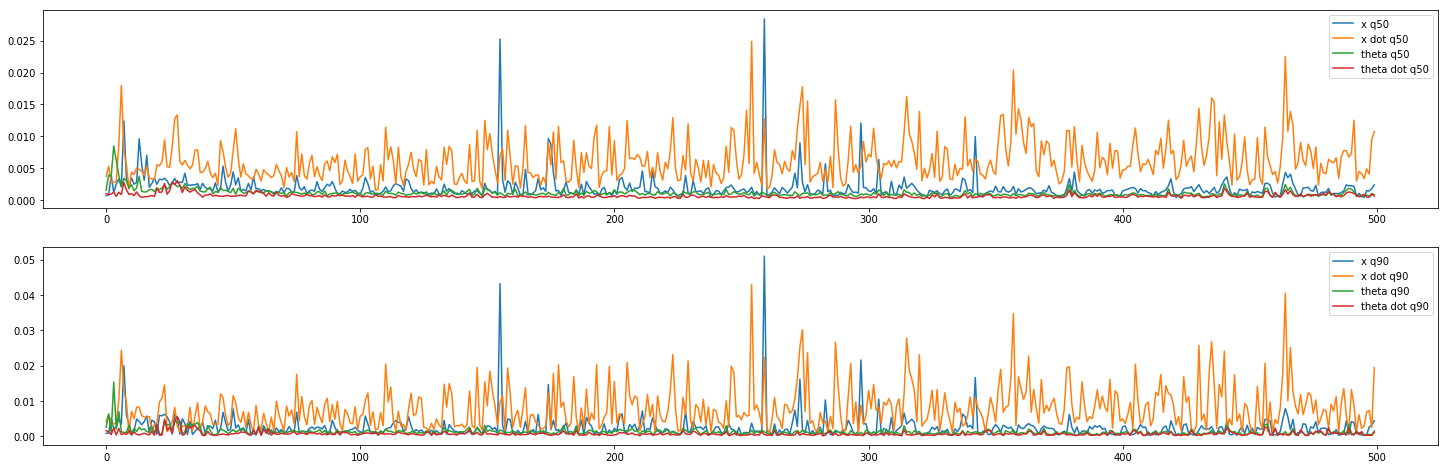

In [7]:
array_pq_losses = np.array(pq_losses).T
labels = ['x q50','x q90','x dot q50','x dot q90','theta q50','theta q90','theta dot q50','theta dot q90']
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (25,8))
for i in range(array_pq_losses.shape[0]):
    if i%2 == 0:
        ax1.plot(array_pq_losses[i], label = labels[i])
    else:
        ax2.plot(array_pq_losses[i], label = labels[i])
ax1.legend()
# ax1.set_ylim(0.0,2.0)
ax2.legend()
# ax2.set_ylim(0.0,2.0)
plt.show()

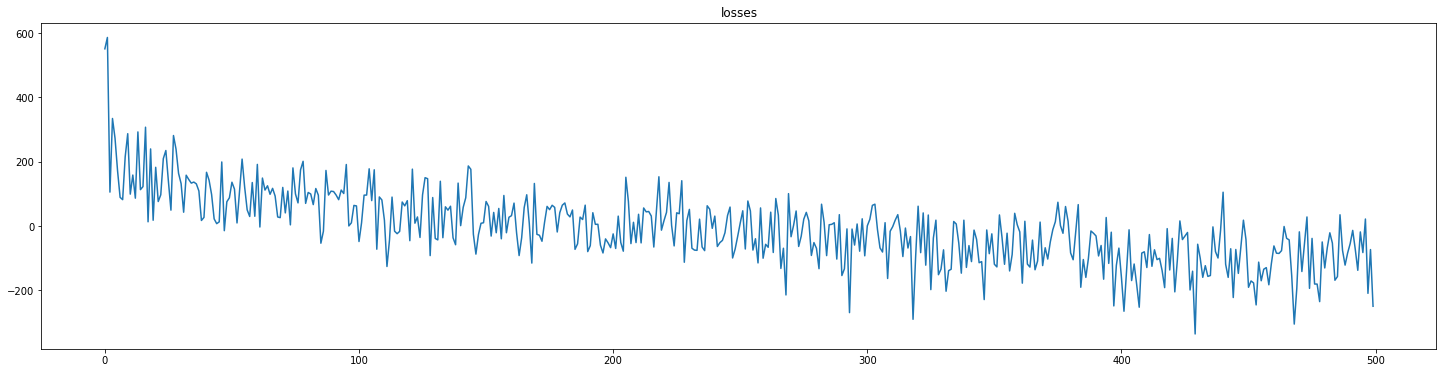

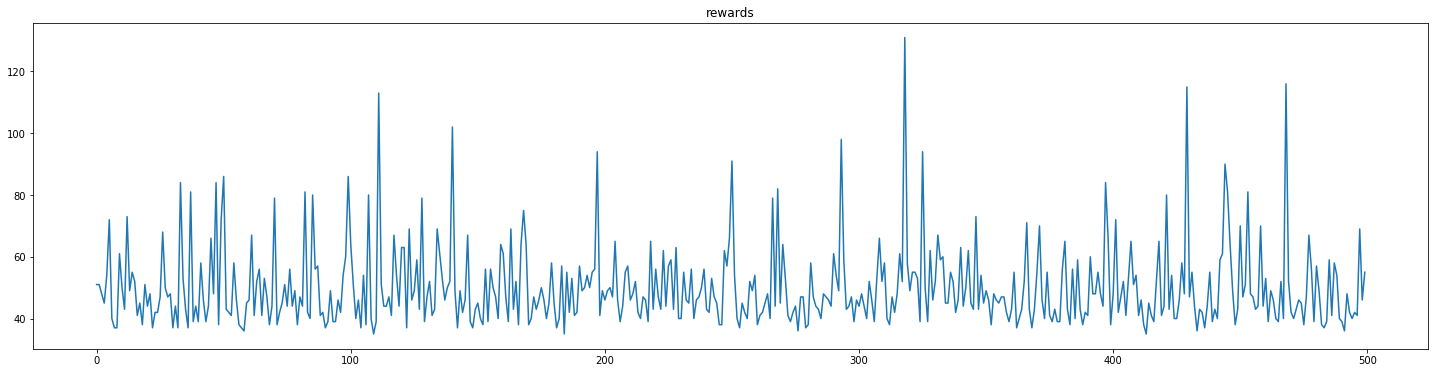

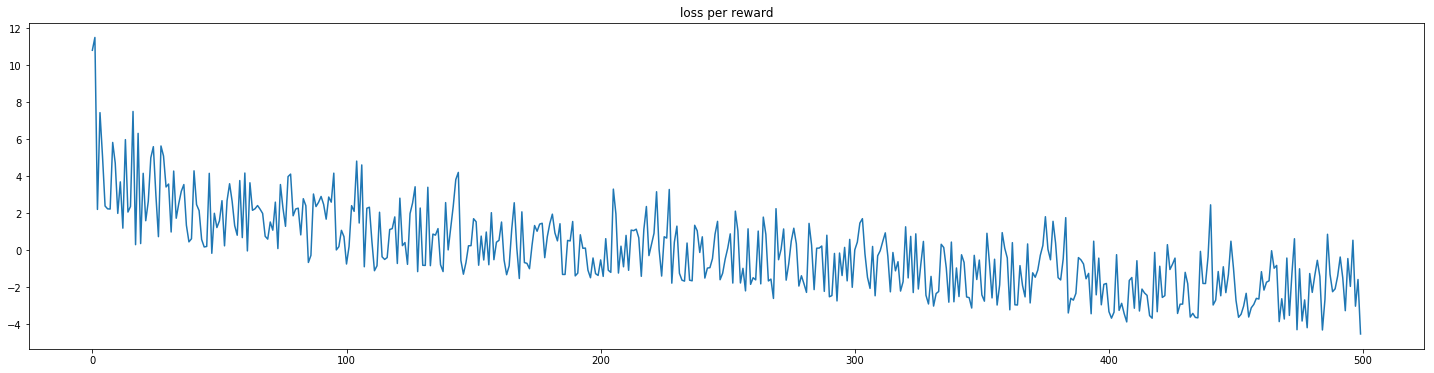

In [8]:
plt.figure(figsize=(25,6))
plt.plot(losses)
plt.title('losses')
plt.show()
plt.figure(figsize=(25,6))
plt.plot(rewards)
plt.title('rewards')
plt.show()
plt.figure(figsize=(25,6))
plt.plot([loss/reward for loss,reward in zip(losses,rewards)])
plt.title('loss per reward')
# plt.ylim(0,500)
plt.show()

In [ ]:
array_squared_errors = np.array(squared_errors)
for i in range(0,1000,25):
    f, ax = plt.subplots(figsize=(25,6))
    ax.plot(array_squared_errors[i][0], label='x')
    ax.plot(array_squared_errors[i][1],label='x dot')
    ax.plot(array_squared_errors[i][2], label = 'theta')
    ax.plot(array_squared_errors[i][3], label = 'theta dot')
    plt.title(i)
    ax.legend()
    ax.set_xlim([0.0,200])
    plt.show()

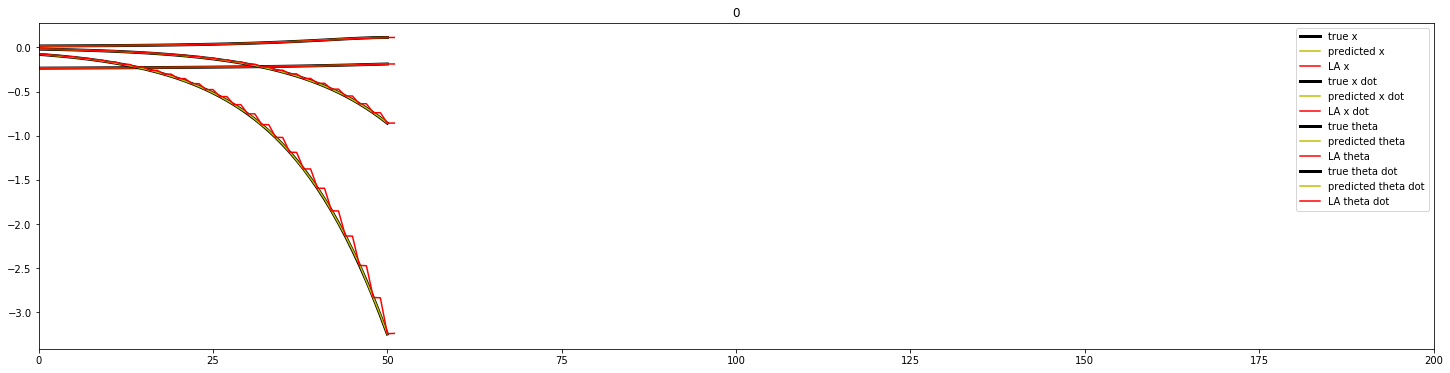

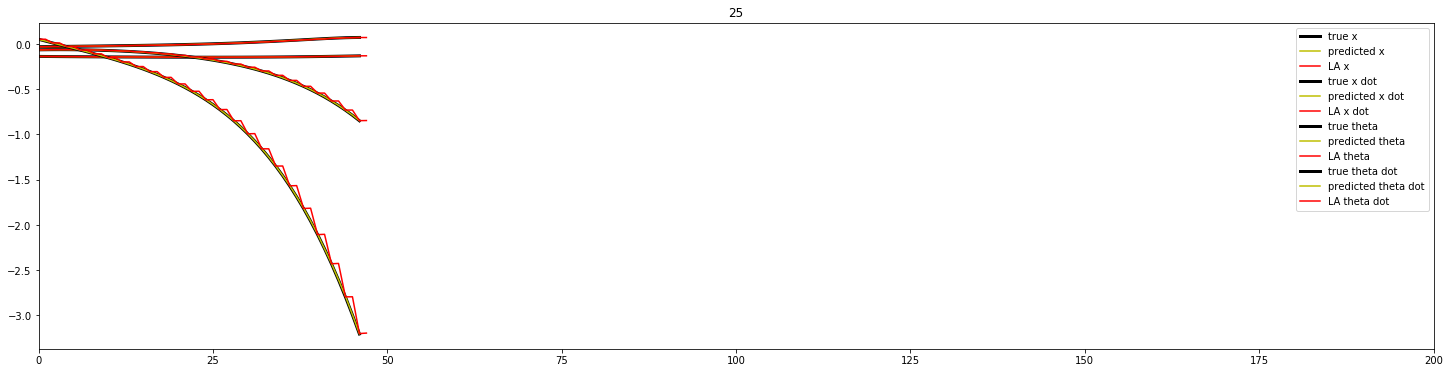

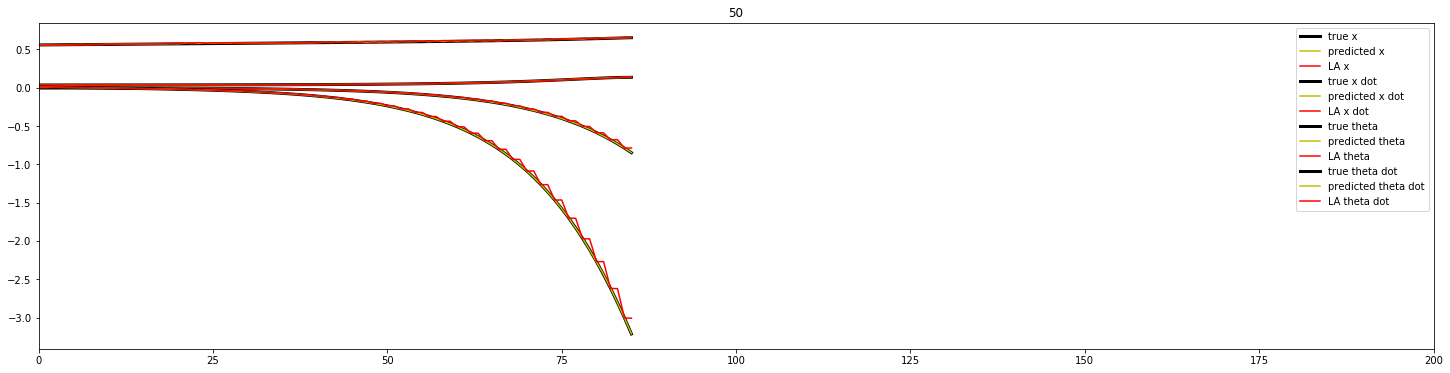

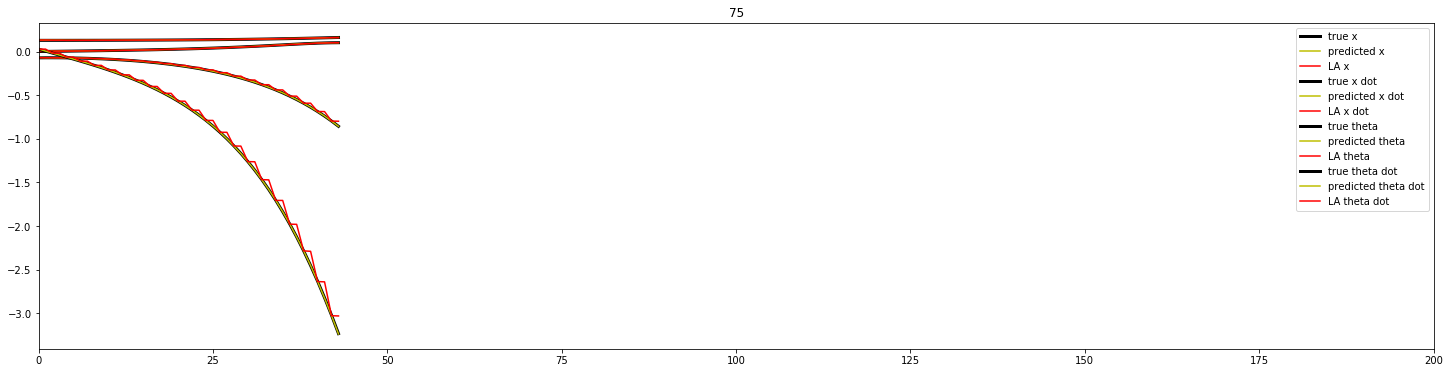

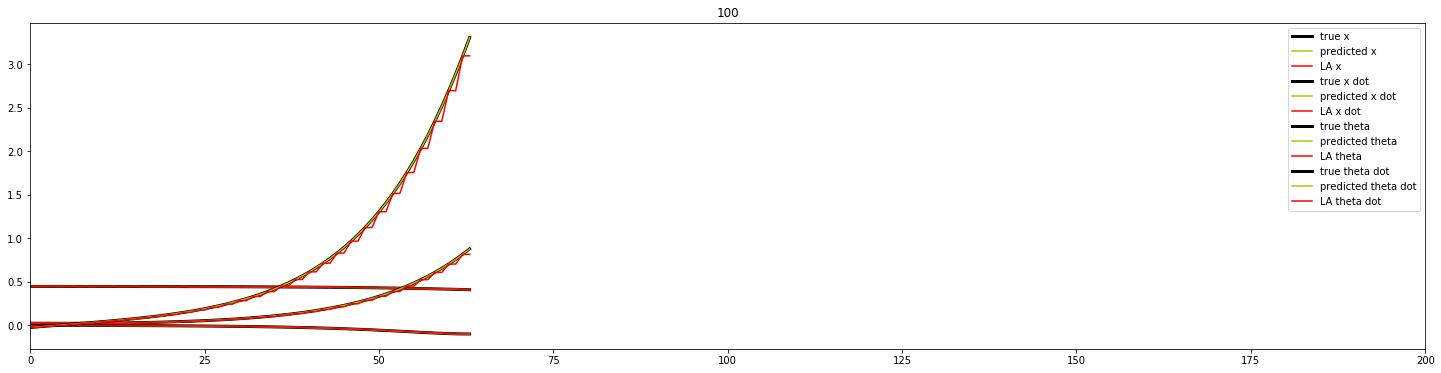

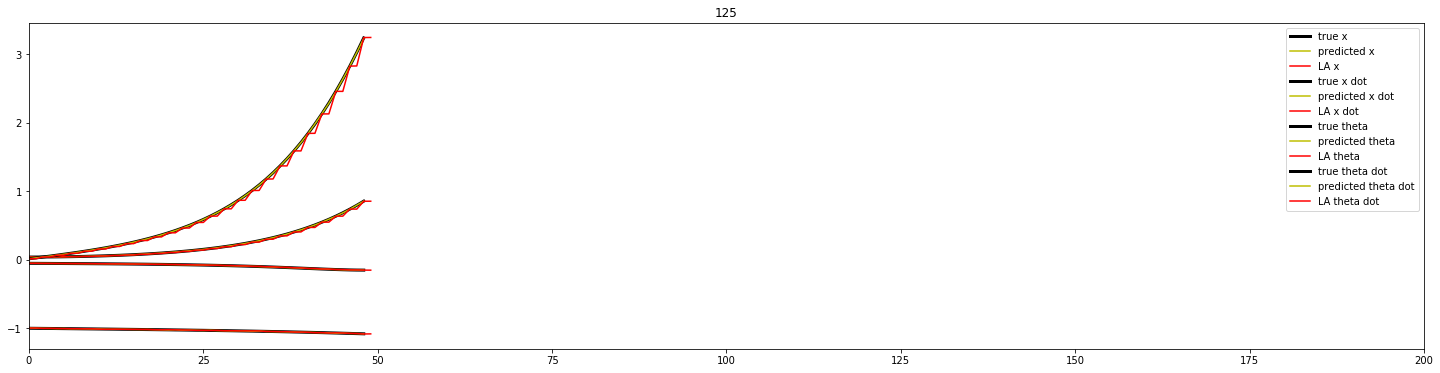

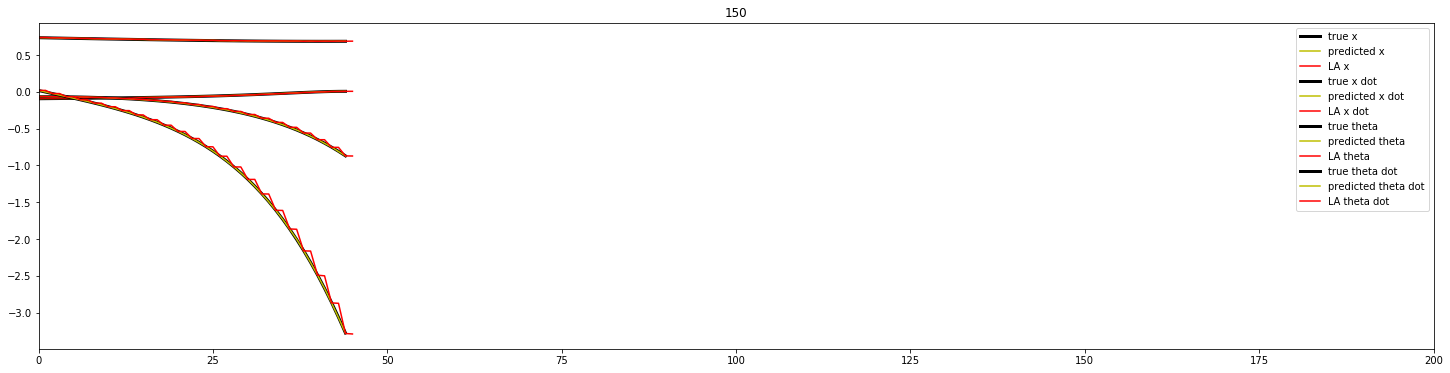

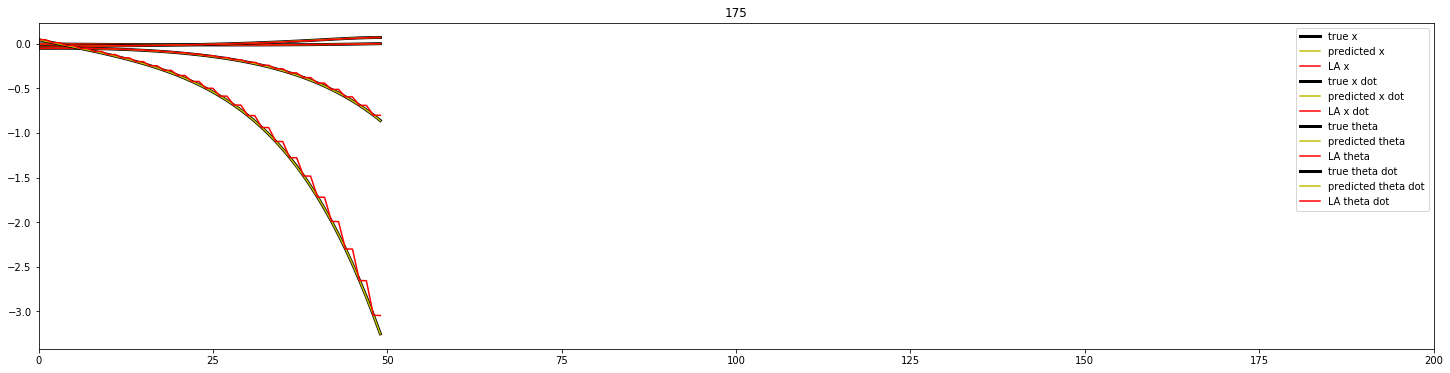

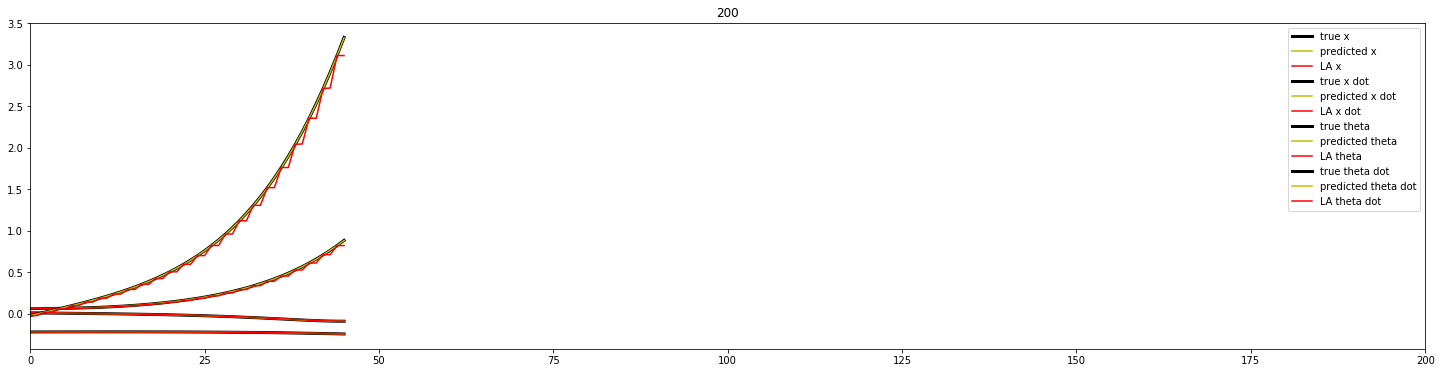

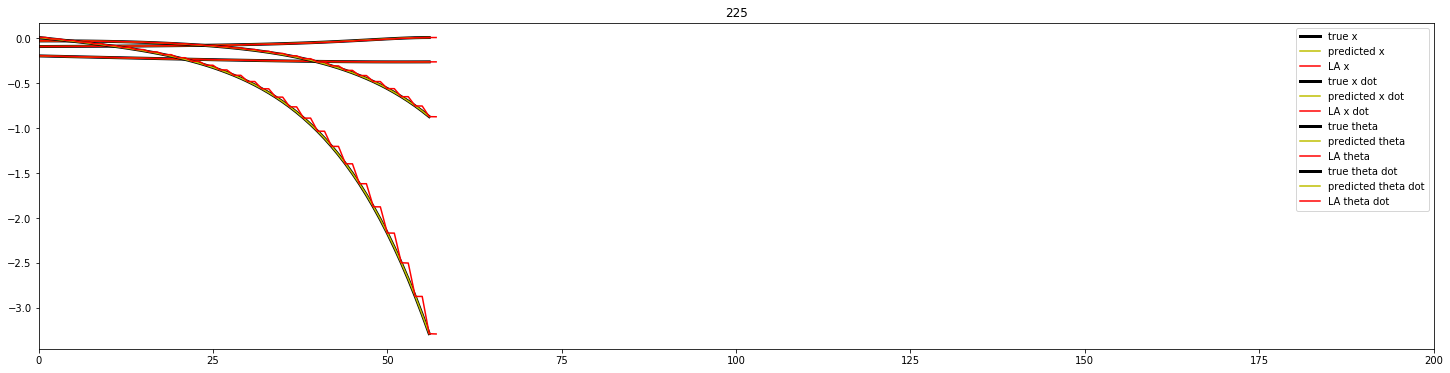

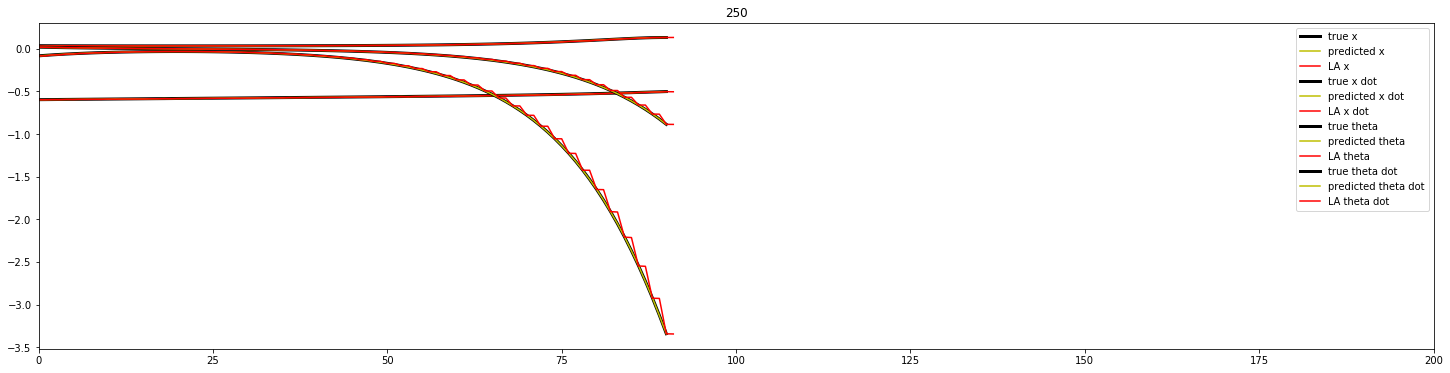

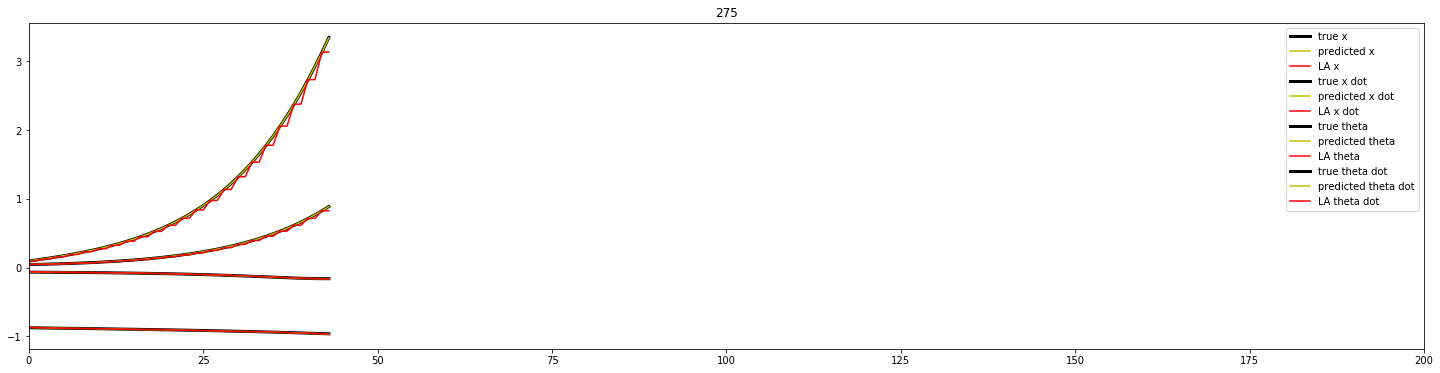

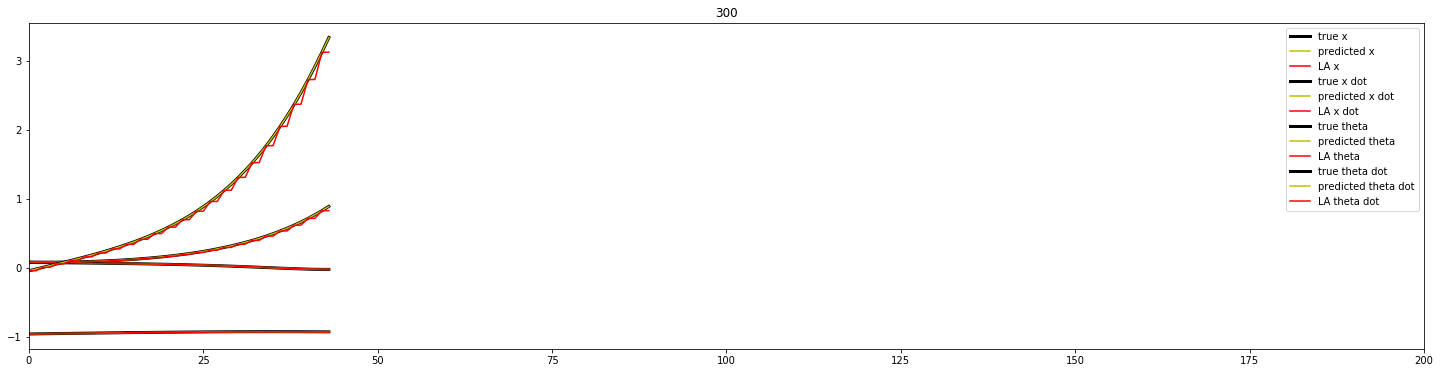

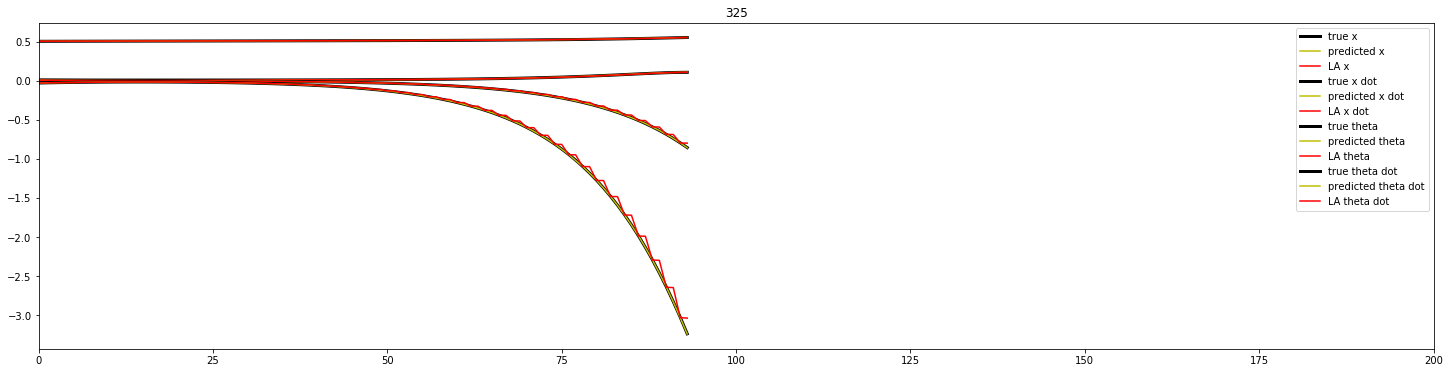

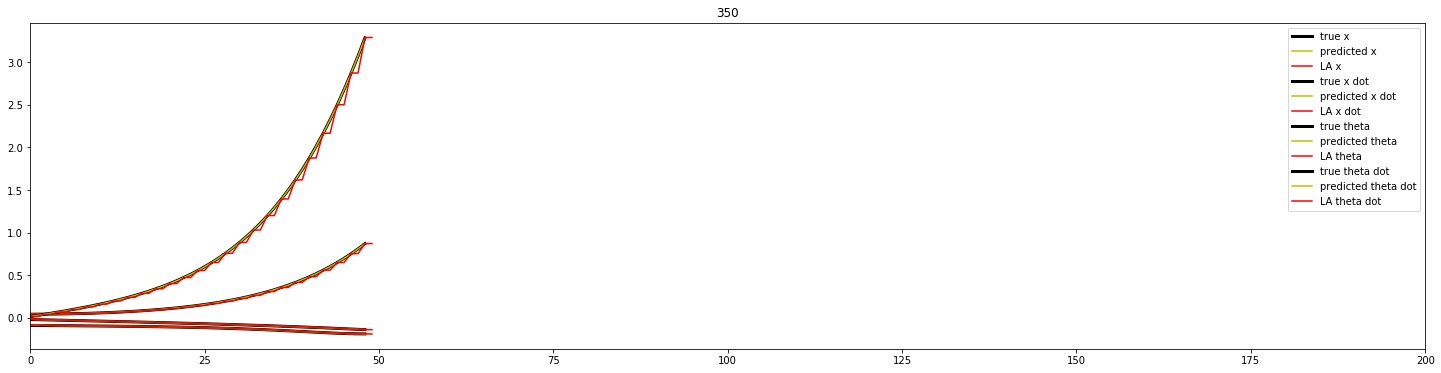

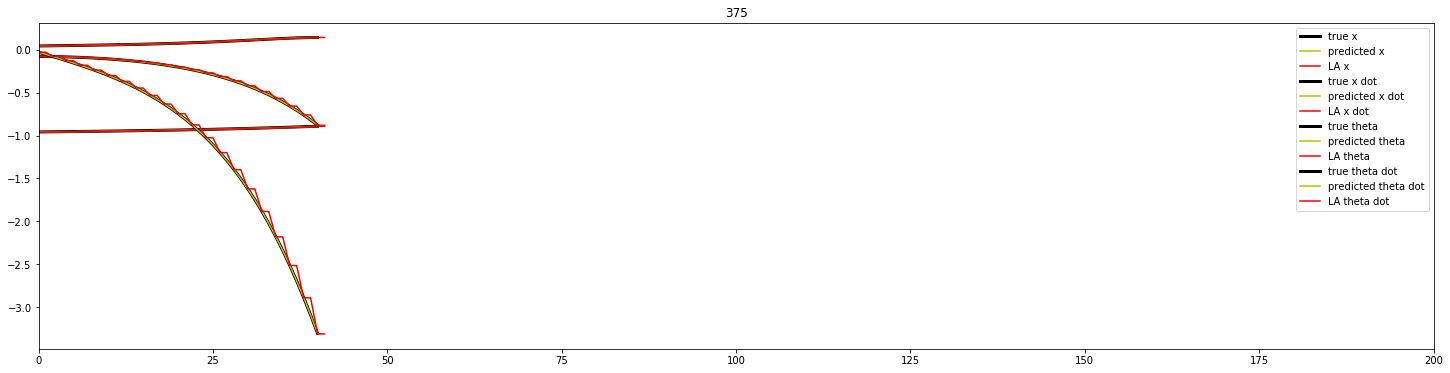

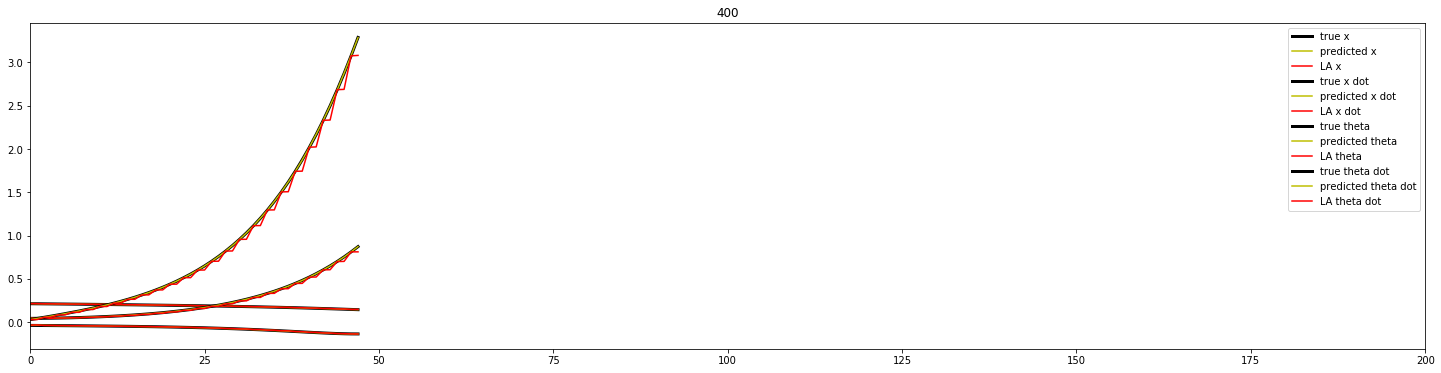

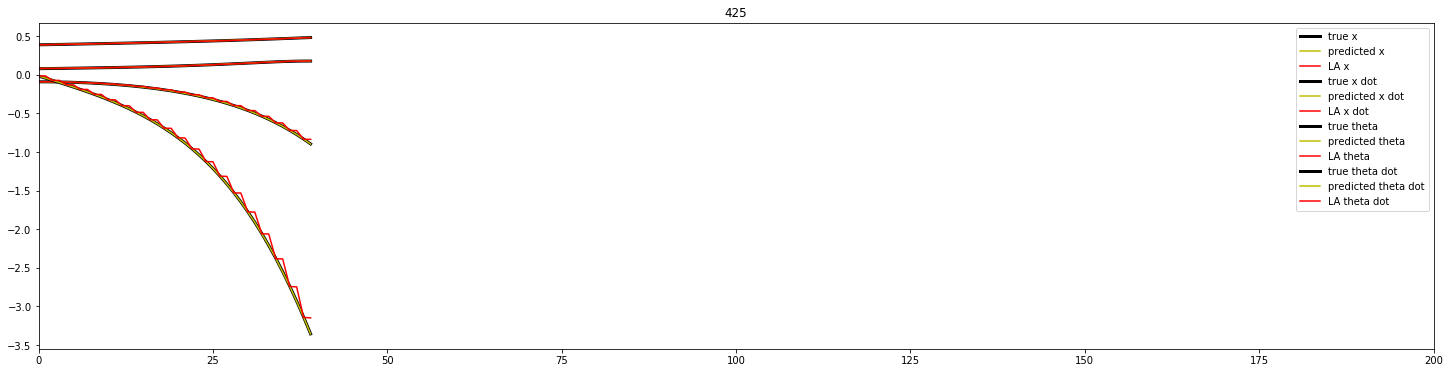

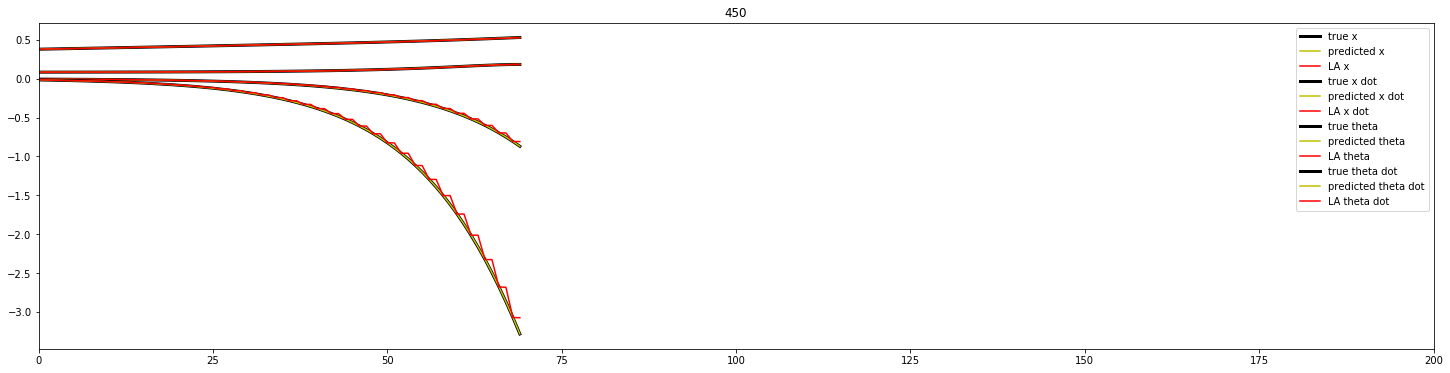

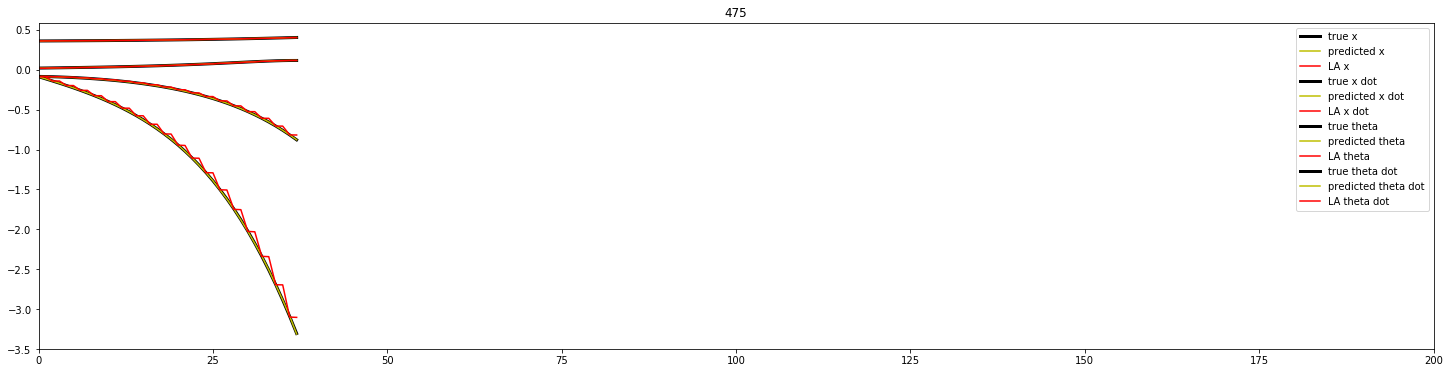

IndexError: index 500 is out of bounds for axis 0 with size 500

<Figure size 1800x432 with 0 Axes>

In [9]:
lookaheadlabels = ['LA x', 'LA x dot', 'LA theta', 'LA theta dot']
predictedlabels = ['predicted x', 'predicted x dot', 'predicted theta', 'predicted theta dot']
truelabels = ['true x','true x dot', 'true theta','true theta dot']
array_actual_trajectories = np.array(actual_trajectories)
for k in range(0,1000,25):
    plt.figure(figsize=(25,6))
    for j in range(4):
        plt.plot(np.squeeze(np.array([array_actual_trajectories[k][j][i] for i in range(len(array_actual_trajectories[k][j]))])), label = truelabels[j], color = 'k',linewidth=3)
        plt.plot(predicted_trajectories[k].numpy()[j], label=predictedlabels[j], color = 'y')
        plt.plot(np.array(look_ahead_predictions[k]).T[j], label = lookaheadlabels[j], color = 'r')
#     plt.legend(['x', 'x dot','theta', 'theta dot', 'x', 'x dot','theta', 'theta dot'])
    plt.legend()
    plt.title(k)
    plt.xlim(0,200)
    plt.show()